x⋅sin(5⋅x)

Compiling model...
'compile' took 0.000266 s

Training model...

Step      Train loss    Test loss     Test metric
0         [2.16e-01]    [2.16e-01]    []  
1000      [1.36e-04]    [1.36e-04]    []  
2000      [1.43e-04]    [1.43e-04]    []  
3000      [6.76e-05]    [6.76e-05]    []  
4000      [4.93e-05]    [4.93e-05]    []  
5000      [3.44e-05]    [3.44e-05]    []  
6000      [2.81e-05]    [2.81e-05]    []  
7000      [2.36e-05]    [2.36e-05]    []  
8000      [1.92e-05]    [1.92e-05]    []  
9000      [1.55e-05]    [1.55e-05]    []  
10000     [1.26e-05]    [1.26e-05]    []  

Best model at step 10000:
  train loss: 1.26e-05
  test loss: 1.26e-05
  test metric: []

'train' took 15.794098 s

Saving loss history to c:\Users\yesda\Tiedostot\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\Tiedostot\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\Tiedostot\PINN_testing\test.dat ...


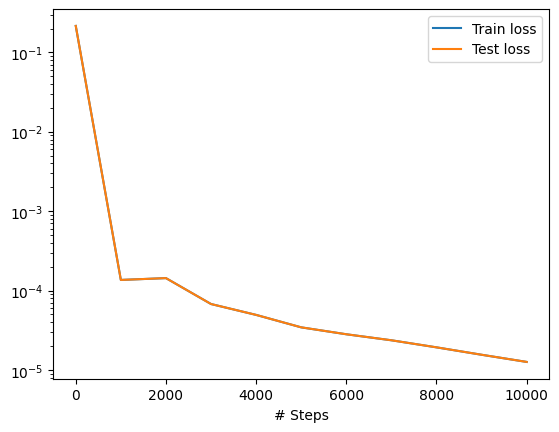

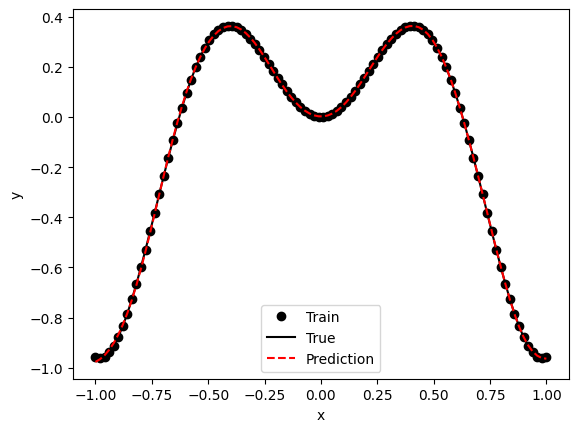

In [31]:
#damped sine wave
import deepxde as dde
import numpy as np
import tensorflow as tf
import sympy as sy
import os
os.environ['DDE_BACKEND'] = 'tensorflow'
sy.init_printing(use_latex='mathjax')
x=sy.symbols('x')
y=x *sy.sin(5 * x)
display(y)

def func(x):
    return x * np.sin(5 * x)

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, func,num_train=100,num_test=100)
net = dde.maps.FNN([1] + [20] * 3 + [1], "tanh","Glorot uniform")
model = dde.Model(data, net)
model.compile("adam",lr=0.001)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [2]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from deepxde.backend import tf
from scipy.special import gamma
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'

alpha0 = 1.8
alpha = dde.Variable(1.5)

# Backend tensorflow.compat.v1
def fpde(x, y, int_mat):
    r"""\int_theta D_theta^alpha u(x)"""
    if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
        int_mat = tf.SparseTensor(*int_mat)
        lhs = tf.sparse_tensor_dense_matmul(int_mat, y)
    else:
        lhs = tf.matmul(int_mat, y)
        lhs = lhs[:, 0]
        lhs *= -tf.exp(tf.lgamma((1 - alpha) / 2) + tf.lgamma((2 + alpha) / 2)) / (
        2 * np.pi ** 1.5
    )
    x = x[: tf.size(lhs)]
    rhs = (
        2 ** alpha0
        * gamma(2 + alpha0 / 2)
        * gamma(1 + alpha0 / 2)
        * (1 - (1 + alpha0 / 2) * tf.reduce_sum(x ** 2, axis=1)))
    return lhs - rhs


def func(x):
    return (1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2) ** (1 + alpha0 / 2)


geom = dde.geometry.Disk([0, 0], 1)
observe_x = geom.random_points(30)
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x))

data = dde.data.FPDE(
    geom,
    fpde,
    alpha,
    observe_y,
    [8, 100],
    num_domain=64,
    anchors=observe_x,
    solution=func,
)

net = dde.nn.FNN([2] + [20] * 4 + [1], "tanh", "Glorot normal")
net.apply_output_transform(lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3, loss_weights=[1, 100], external_trainable_variables=[alpha])
variable = dde.callbacks.VariableValue(alpha, period=1000)
losshistory, train_state = model.train(iterations=10000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000123 s

Training model...



AttributeError: 'function' object has no attribute 'reduce_sum'

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create a Sequential model
model = Sequential()

# Add layers to the model
model.add(Dense(units=64, activation='relu', input_shape=(784,)))
model.add(Dense(units=10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

sin(5⋅x)

Compiling model...
'compile' took 0.000347 s

Training model...

Step      Train loss    Test loss     Test metric
0         [6.02e-01]    [6.02e-01]    []  
1000      [1.70e-03]    [1.70e-03]    []  
2000      [3.39e-04]    [3.39e-04]    []  
3000      [8.88e-05]    [8.88e-05]    []  
4000      [4.80e-05]    [4.80e-05]    []  
5000      [2.77e-05]    [2.77e-05]    []  
6000      [1.67e-05]    [1.67e-05]    []  
7000      [1.20e-05]    [1.20e-05]    []  
8000      [9.36e-06]    [9.36e-06]    []  
9000      [7.64e-06]    [7.64e-06]    []  
10000     [4.94e-06]    [4.94e-06]    []  

Best model at step 10000:
  train loss: 4.94e-06
  test loss: 4.94e-06
  test metric: []

'train' took 12.778461 s

Saving loss history to c:\Users\yesda\Tiedostot\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\Tiedostot\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\Tiedostot\PINN_testing\test.dat ...


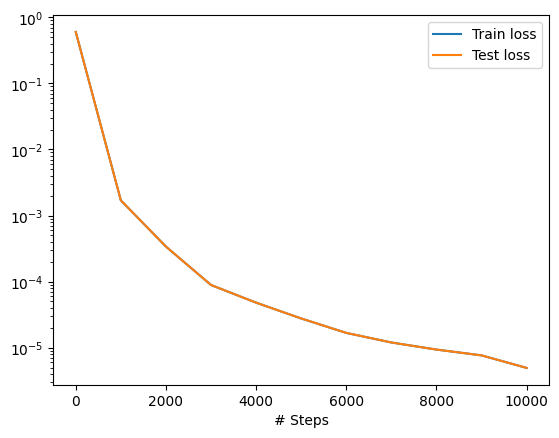

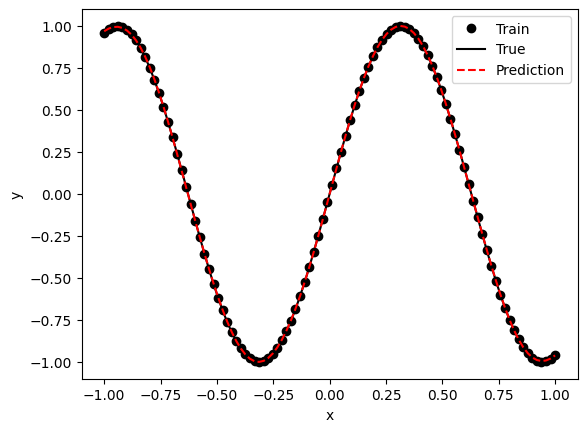

In [33]:
import deepxde as dde
import numpy as np
import sympy as sy
sy.init_printing(use_latex='mathjax')
x=sy.symbols('x')
y=sy.sin(5 * x)
display(y)

def func(x):
    return np.sin(5 * x)

# Geometry: the domain of the function
geom = dde.geometry.Interval(-1, 1)

# Generate training data based on the function
num_train = 100
num_test = 100
data = dde.data.Function(geom, func, num_train, num_test)

# Neural network: 1 input layer (dimension of x), 2 hidden layers of 20 neurons each, 1 output layer
layer_size = [1] + [20]*2 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

# Model
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=10000)
dde.saveplot(losshistory,train_state,issave=True,isplot=True)